## Prepare Terrain Data

In [1]:
import random

def makeTerrainData(n_points=1000):
###############################################################################
### make the toy dataset
    random.seed(42)
    grade = [random.random() for ii in range(0,n_points)]
    bumpy = [random.random() for ii in range(0,n_points)]
    error = [random.random() for ii in range(0,n_points)]
    y = [round(grade[ii]*bumpy[ii]+0.3+0.1*error[ii]) for ii in range(0,n_points)]
    for ii in range(0, len(y)):
        if grade[ii]>0.8 or bumpy[ii]>0.8:
            y[ii] = 1.0

### split into train/test sets
    X = [[gg, ss] for gg, ss in zip(grade, bumpy)]
    split = int(0.75*n_points)
    X_train = X[0:split]
    X_test  = X[split:]
    y_train = y[0:split]
    y_test  = y[split:]

    grade_sig = [X_train[ii][0] for ii in range(0, len(X_train)) if y_train[ii]==0]
    bumpy_sig = [X_train[ii][1] for ii in range(0, len(X_train)) if y_train[ii]==0]
    grade_bkg = [X_train[ii][0] for ii in range(0, len(X_train)) if y_train[ii]==1]
    bumpy_bkg = [X_train[ii][1] for ii in range(0, len(X_train)) if y_train[ii]==1]

    training_data = {"fast":{"grade":grade_sig, "bumpiness":bumpy_sig}
            , "slow":{"grade":grade_bkg, "bumpiness":bumpy_bkg}}


    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    test_data = {"fast":{"grade":grade_sig, "bumpiness":bumpy_sig}
            , "slow":{"grade":grade_bkg, "bumpiness":bumpy_bkg}}

    return X_train, y_train, X_test, y_test

## Create Function to Visualise Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from time import time

def prettyPicture(clf, X_test, y_test):
    x_min = 0.0; x_max = 1.0
    y_min = 0.0; y_max = 1.0
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    h = .01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.pcolormesh(xx, yy, Z, cmap=pl.cm.seismic)

    # Plot also the test points
    grade_sig = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==0]
    bumpy_sig = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==0]
    grade_bkg = [X_test[ii][0] for ii in range(0, len(X_test)) if y_test[ii]==1]
    bumpy_bkg = [X_test[ii][1] for ii in range(0, len(X_test)) if y_test[ii]==1]

    plt.scatter(grade_sig, bumpy_sig, color = "b", label="fast")
    plt.scatter(grade_bkg, bumpy_bkg, color = "r", label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")

    plt.savefig("test.png")

import base64
import json
import subprocess

def output_image(name, format, bytes):
    image_start = "BEGIN_IMAGE_f9825uweof8jw9fj4r8"
    image_end = "END_IMAGE_0238jfw08fjsiufhw8frs"
    data = {}
    data['name'] = name
    data['format'] = format
    data['bytes'] = base64.encodestring(bytes)
    print(image_start+json.dumps(data)+image_end)

## Investigate Naive Bayes Accuracy

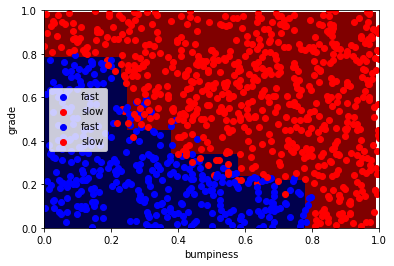

time: 0.003
The best parameters are None
Accuracy: 0.884


In [10]:
import matplotlib.pyplot as plt

features_train, labels_train, features_test, labels_test = makeTerrainData()

### the training data (features_train, labels_train) have both "fast" and "slow"
### points mixed together--separate them so we can give them different colors
### in the scatterplot and identify them visually
grade_fast = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii]==0]
bumpy_fast = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii]==0]
grade_slow = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii]==1]
bumpy_slow = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii]==1]

#### initial visualization
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.scatter(bumpy_fast, grade_fast, color = "b", label="fast")
plt.scatter(grade_slow, bumpy_slow, color = "r", label="slow")
plt.legend()
plt.xlabel("bumpiness")
plt.ylabel("grade")
plt.show()
################################################################################

best_accuracy = 0.0
best_kwargs = None
best_clf = None


# Modified code based on:
# https://github.com/jdamiani27/Intro-to-Machine-Learning/blob/master/choose_your_own/your_algorithm.py
# Alternatively, tune hyperparameters via an exhaustive Grid Search or a Randomized Search algorithm:
# http://www.pyimagesearch.com/2016/08/15/how-to-tune-hyperparameters-with-python-and-scikit-learn/


################################################################################
from sklearn.naive_bayes import GaussianNB

t0 = time()

kwargs = None

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = clf.score(features_test, labels_test)

if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_kwargs = kwargs
    best_clf = clf
################################################################################

print("time:", round((time() - t0), 3))
print("The best parameters are", best_kwargs)
print("Accuracy:", best_accuracy)

try:
    prettyPicture(best_clf, features_test, labels_test)
except NameError:
    pass

## Investigate Support Vector Machines Accuracy

time: 426.598
The best parameters are {'C': 1000, 'gamma': 10, 'kernel': 'sigmoid', 'probability': False, 'shrinking': False}
Accuracy: 0.948


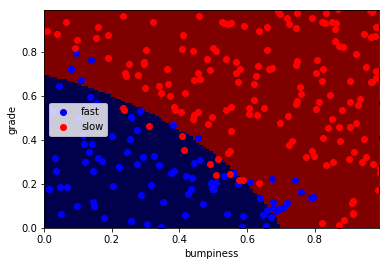

In [11]:
from sklearn import svm

t0 = time()

best_accuracy = 0.0
best_kwargs = None
best_clf = None

kwargs = {
    'C' : None,
    'gamma' : None,
    'kernel' : None,
    'probability' : None,
    'shrinking' : None
}

import numpy as np

for C in [1, 10, 100, 1000]:
    for gamma in [0.1, 1, 10]:
        for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
            for probability in (True, False):
                for shrinking in (True, False):
                    kwargs['C'] = C
                    kwargs['gamma'] = gamma
                    kwargs['kernel'] = kernel
                    kwargs['probability'] = probability
                    kwargs['shrinking'] = shrinking

                clf = svm.SVC(**kwargs)
                clf.fit(features_train, labels_train)
                pred = clf.predict(features_test)
                accuracy = clf.score(features_test, labels_test)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_kwargs = kwargs
                    best_algorithm = 'SVM'
                    best_clf = clf
################################################################################

print("time:", round((time() - t0), 3))
print("The best parameters are", best_kwargs)
print("Accuracy:", best_accuracy)

plt.show()

try:
    prettyPicture(best_clf, features_test, labels_test)
except NameError:
    pass

## Investigate k Nearest Neighbors Accuracy

time: 7.237
The best parameters are {'n_neighbors': 29, 'weights': 'distance', 'algorithm': 'brute', 'metric': 'cityblock', 'p': 3}
Accuracy: 0.944


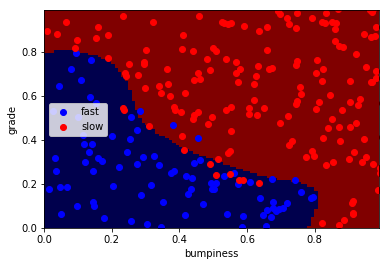

In [12]:
from sklearn.neighbors import KNeighborsClassifier

t0 = time()

best_accuracy = 0.0
best_kwargs = None
best_clf = None

kwargs = {
    'n_neighbors' : None,
    'weights' : None,
    'algorithm' : None,
    'metric' : None,
    'p' : None
}

for n_neighbors in np.arange(1, 30, 2):
    for weights in ('uniform', 'distance'):
        for algorithm in ("auto", "ball_tree", "kd_tree", "brute"):
            for metric in ("euclidean", "cityblock"):
                for p in (1, 2, 3):
                    kwargs['n_neighbors'] = n_neighbors
                    kwargs['weights'] = weights
                    kwargs['algorithm'] = algorithm
                    kwargs['metric'] = metric
                    kwargs['p'] = p

                    clf = KNeighborsClassifier(**kwargs)
                    clf.fit(features_train, labels_train)
                    pred = clf.predict(features_test)
                    accuracy = clf.score(features_test, labels_test)

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_kwargs = kwargs
                        best_algorithm = 'kNN'
                        best_clf = clf
################################################################################

print("time:", round((time() - t0), 3))
print("The best parameters are", best_kwargs)
print("Accuracy:", best_accuracy)

plt.show()

try:
    prettyPicture(best_clf, features_test, labels_test)
except NameError:
    pass

## Investigate Random Forest Accuracy

time: 184.209
The best parameters are {'n_estimators': 100, 'criterion': 'entropy', 'max_features': None, 'max_depth': None, 'bootstrap': False, 'n_jobs': -1}
Accuracy: 0.936


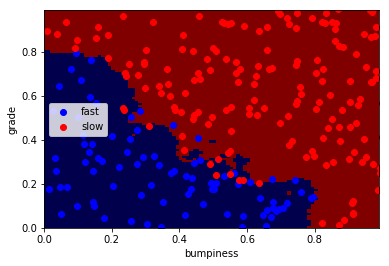

In [13]:
from sklearn.ensemble import RandomForestClassifier

t0 = time()

best_accuracy = 0.0
best_kwargs = None
best_clf = None

kwargs = {
    'n_estimators' : None,
    'criterion' : None,
    'max_features' : None,
    'max_depth' : None,
    'bootstrap' : None,
    'n_jobs' : -1
}

for n_estimators in [1, 10, 100]:
    for criterion in ("gini", "entropy"):
        for max_features in ("auto", "sqrt", "log2", None):
            for max_depth in tuple(np.arange(5, 100, 10)) + (None,):
                for bootstrap in (True, False):
                    kwargs['n_estimators'] = n_estimators
                    kwargs['criterion'] = criterion
                    kwargs['max_features'] = max_features
                    kwargs['max_depth'] = max_depth
                    kwargs['bootstrap'] = bootstrap

                    clf = RandomForestClassifier(**kwargs)
                    clf.fit(features_train, labels_train)
                    pred = clf.predict(features_test)
                    accuracy = clf.score(features_test, labels_test)

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_kwargs = kwargs
                        best_algorithm = 'Random Forest'
                        best_clf = clf
################################################################################

print("time:", round((time() - t0), 3))
print("The best parameters are", best_kwargs)
print("Accuracy:", best_accuracy)

plt.show()

try:
    prettyPicture(best_clf, features_test, labels_test)
except NameError:
    pass

## Investigate AdaBoost Accuracy

time: 2.771
The best parameters are {'n_estimators': 54, 'algorithm': 'SAMME.R'}
Accuracy: 0.924


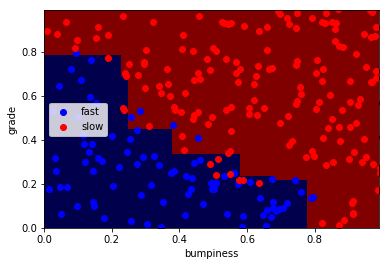

In [15]:
from sklearn.ensemble import AdaBoostClassifier

t0 = time()

best_accuracy = 0.0
best_kwargs = None
best_clf = None

kwargs = {
    'n_estimators' : None,
    'algorithm' : None
}

for n_estimators in range(45, 55):
    for algorithm in ("SAMME", "SAMME.R"):
        kwargs['n_estimators'] = n_estimators
        kwargs['algorithm'] = algorithm

        clf = AdaBoostClassifier(**kwargs)
        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
        accuracy = clf.score(features_test, labels_test)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kwargs = kwargs
            best_algorithm = 'AdaBoost'
            best_clf = clf
################################################################################

print("time:", round((time() - t0), 3))
print("The best parameters are", best_kwargs)
print("Accuracy:", best_accuracy)

plt.show()

try:
    prettyPicture(best_clf, features_test, labels_test)
except NameError:
    pass